# Decision trees

In [10]:
# HIDE CODE

# Python setup
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from ipywidgets import interactive
from ipywidgets import interact, IntSlider

*This tutorial is mainly based on content from the excellent iOS app [Tinkerstellar](https://tinkerstellar.com) and documentations from [scikit-learn](https://scikit-learn.org/stable/).*

Decision trees are extremely intuitive ways to classify or label objects - you simply ask a series of questions designed to zero-in on the classification. As a first example, we use the [iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. The data consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 

```{image} ../_static/img/iris.png
:alt: iris
:class: bg-primary mb-1
:width: 600px
:align: center
```

To gain a better understanding of how decision trees work, we first will take a look at pairs of features. For each pair of iris features (e.g. sepal length and sepal width), the decision tree learns decision boundaries made of combinations of simple thresholding rules inferred from the training samples ([scikit-learn developers](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)):


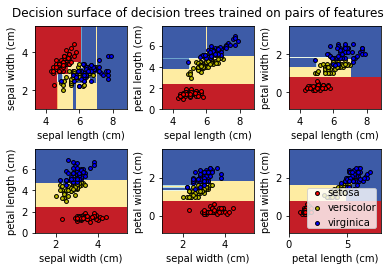

In [24]:
# HIDE CODE

# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=iris.target_names[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")

Next, we display the structure of a single decision tree trained on all the features together ([scikit-learn developers](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)):

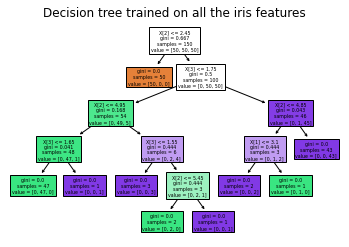

In [25]:
# HIDE CODE

iris = load_iris()

clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

The binary splitting makes the procedure very efficient. In training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information. 

:::{Note}
Take a look at R2D3's ["A visual introduction to machine learning" http://www.r2d3.us/visual-intro-to-machine-learning-part-1/] to get a more detailed visual explanation of how decision trees work.
:::

## Interactive example

Next, we use an example data with 4 centers.

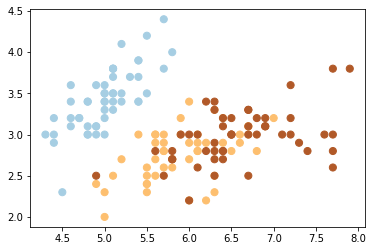

In [26]:
# HIDE CODE
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

#X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired);

In [27]:
# HIDE CODE

def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None):
    estimator.fit(X, y)

    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap=plt.cm.Paired)
    plt.clim(y.min(), y.max())
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.Paired)
    plt.axis('off')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    plt.clim(y.min(), y.max())
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i < 0:
            return

        tree = estimator.tree_
        
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-r')
            plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-r')
            plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

We use a custom function which generates a (static) plot of a decision tree classifier with specified parameters.

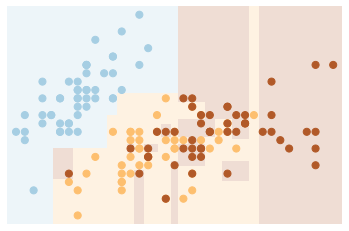

In [28]:
# create model
clf = DecisionTreeClassifier()
# visualize boundaries of classifier with custom function
visualize_tree(clf, X, y, boundaries=False)

Create an interactive plot:

In [29]:
def interactive_tree(depth=1):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    visualize_tree(clf, X, y)
    plt.show()

interactive(interactive_tree, depth=(1, 5))

interactive(children=(IntSlider(value=1, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

:::{Note}
You need to run this notebook on your machine or [colab](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj2kMTrtPD1AhXm7rsIHWhzDtsQFnoECAUQAQ&url=https%3A%2F%2Fcolab.research.google.com%2F&usg=AOvVaw3A5aPK2kLFzKOzb6sOckVw) to execute the interactive plot
:::

Try changing the slider position and notice that at each increase in depth, every node is split in two except those nodes which contain only a single class.

## Overfitting

One issue with decision trees is that it is very easy to create trees which overfit the data. As an example, we will use a random sample of 50% of the iris data to train the model and display the results:

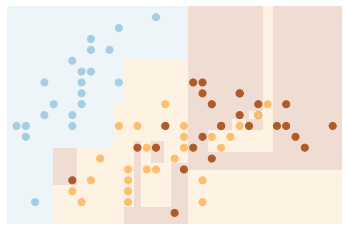

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

clf = DecisionTreeClassifier()

visualize_tree(clf, X_train, y_train, boundaries=False)

Next, we use a different sample to fit another tree: 

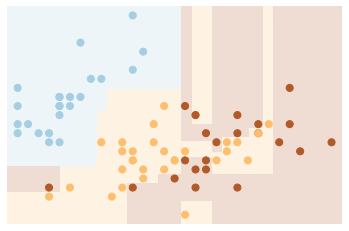

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=123)

clf = DecisionTreeClassifier()

visualize_tree(clf, X_train, y_train, boundaries=False)

Note that the details of the classifications are very different which is an indication of overfitting: when you predict the value for a new point, the result is more reflective of the noise in the model rather than the signal.

:::{Note}
Take a look at R2D3's visual introduction of ["Model Tuning and the Bias-Variance Tradeoff"](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/) to learn more about the concept of overfitting.
:::


## Ensemble of estimators

One possible way to address over-fitting is to use an ensemble method: 

- this is a meta-estimator which essentially averages the results of many individual estimators which over-fit the data. 
- Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up.

### Random forest

One of the most common ensemble methods is the **random forest**, in which the ensemble is made up of many decision trees.

Let's use an ensemble of estimators fit on subsets of the data. We can get an idea of what these might look like as follows:

In [45]:
# HIDE CODE

def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    plt.show()
    
interact(fit_randomized_tree, random_state=IntSlider(
    min=0, max=100, description='Random state', style={'description_width': 'auto'}, continuous_update=False
));

interactive(children=(IntSlider(value=0, continuous_update=False, description='Random state', style=SliderStyl…

Creating a random forest:

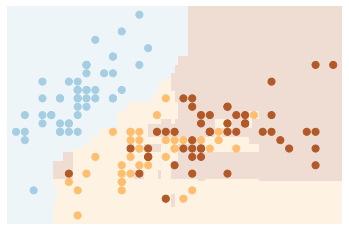

In [46]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)

visualize_tree(clf, X, y, boundaries=False);

By averaging over 100 randomly decision tree models, we end up with an overall model which is a much better fit to our data.

## Regression

Above we were considering random forests within the context of classification. Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables).


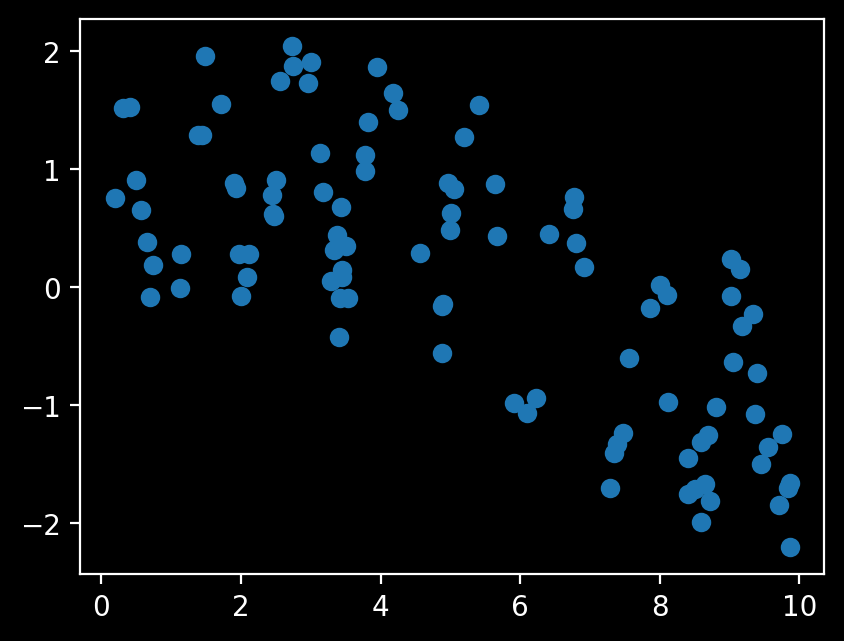

In [8]:
# HIDE CODE

# make data
x = 10 * np.random.rand(100)
def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * np.random.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x)

plt.scatter(x, y);

In [11]:
xfit = np.linspace(0, 10, 1000)

clf = RandomForestRegressor(100)
clf.fit(x[:, None], y)

yfit = clf.predict(xfit[:, None])

Let's plot our data points (in blue) along with our prediction (in red) as well as the "true" function which created our y (in green).

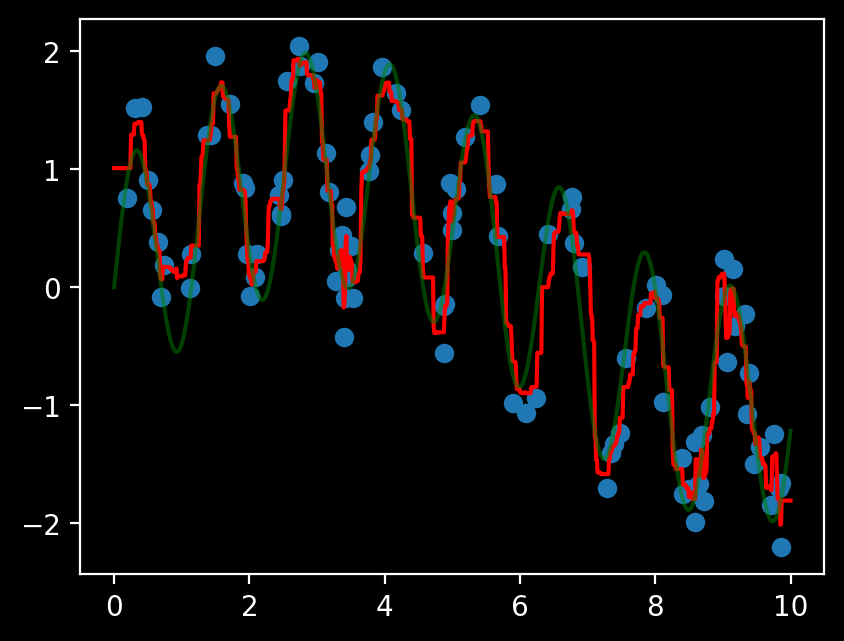

In [13]:
# HIDE CODE
ytrue = model(xfit, 0)

plt.scatter(x, y)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-g', alpha=0.5);

As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us even specifying a multi-period model.

## Hand written digits

### Data

In [15]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [16]:
X = digits.data
y = digits.target

print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


The data in digits.images is a 1797x8x8 array, with each pixel value within an 8x8 grid:

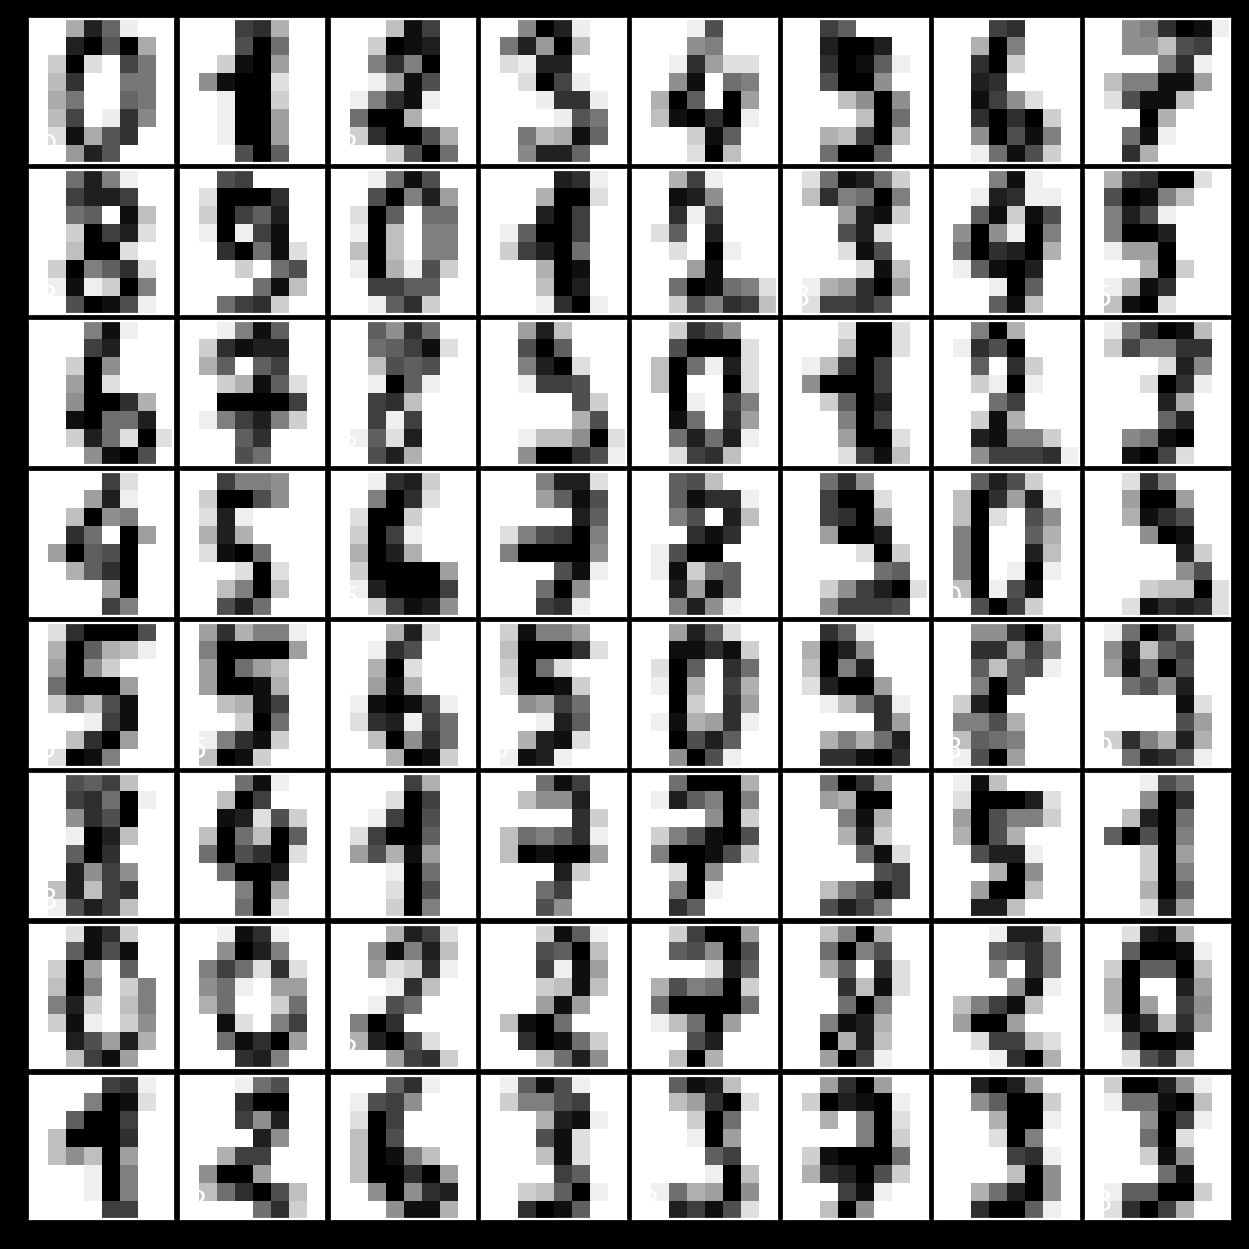

In [17]:
# HIDE CODE
# Set up the figure
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

### Model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(max_depth=11)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Model accuracy: {metrics.accuracy_score(y_pred, y_test):.2f}")

Model accuracy: 0.84


### Classification report

Let's plot the confusion matrix, where each row represents the true label of the sample, while each column represents the predicted label. 

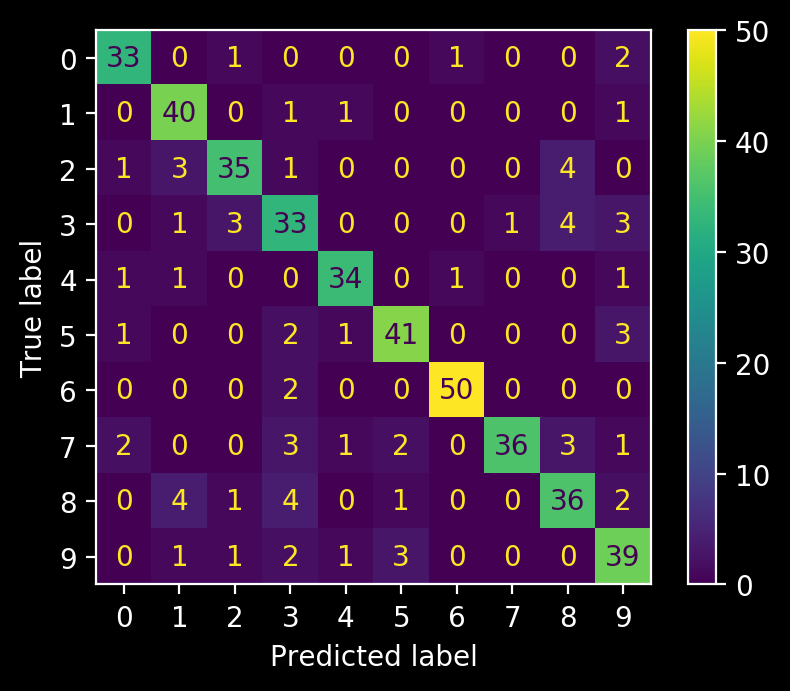

In [19]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Finally, we take a look at the classification report.

In [10]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.895     0.919     0.907        37
           1      0.844     0.884     0.864        43
           2      0.809     0.864     0.835        44
           3      0.714     0.778     0.745        45
           4      0.892     0.868     0.880        38
           5      0.894     0.875     0.884        48
           6      1.000     0.962     0.980        52
           7      0.975     0.812     0.886        48
           8      0.841     0.771     0.804        48
           9      0.736     0.830     0.780        47

    accuracy                          0.856       450
   macro avg      0.860     0.856     0.857       450
weighted avg      0.861     0.856     0.857       450

